# Problem set 5: Clustering (solution)

## Description

**The goal of this problem set is to compute and explore three different clusterings of historical court records.**

## Imports and setup

In [1]:
%matplotlib inline
import numpy as np
import os
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
from   sklearn.datasets import make_blobs
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Our input text file
old_bailey_file = os.path.join('..', '..', 'data', 'old_bailey', 'old_bailey.txt')

## Convenience functions

Creating visualizations of your data and pulling sample texts for individual comparison are important parts of assessing the performance of your model. To make these two tasks easier, I've provided a function to do each one.

Note that the visualization function performs dimension reduction, so that we can plot high-dimensional text data in 2-D space. The clustering operations are performed on the original, high-dimensional data.

In [2]:
# Plotting function
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    from   sklearn.decomposition import TruncatedSVD

    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()
    
# Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            print(texts_array[choice], '\n') # Print each sampled text
        print("###################################")

## Synthetic example

To see how clustering works in `scikit-learn` (it's really easy!), here's a synthetic example.

Note that `X` and `y` are the conventional labels for an input data array and a vector of labels, respectively. You don't have to use these (and may well want to at least give your variables informative suffixes), but you'll see this notation a lot.

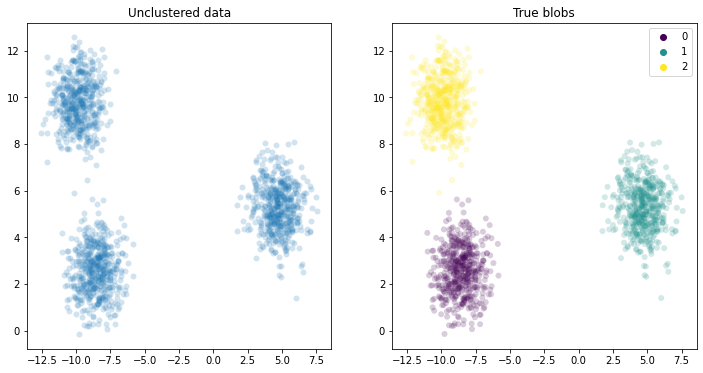

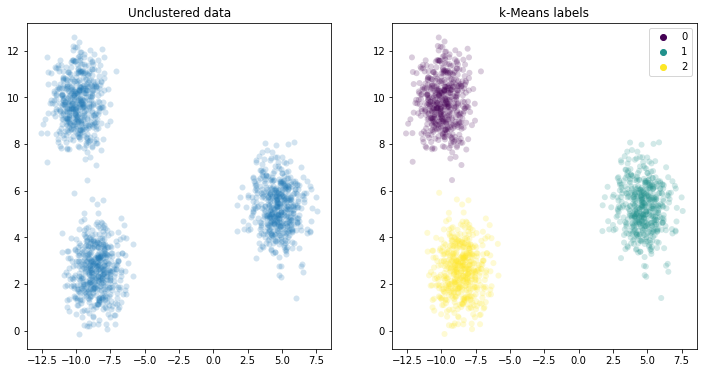

In [3]:
n_samples = 1500 # this many points per blob
X, y = make_blobs(n_samples=n_samples) # Make data and true labels
y_pred = KMeans(n_clusters=3).fit_predict(X) # Perform clustering

plot_compare(X, y, 'True blobs', reduce=False)
plot_compare(X, y_pred, 'k-Means labels', reduce=False)

That's it! Notice that all we needed was to construct input data, set up a clustering object, and call the `fit_predict` method on the input data.

This is what you'll do for the graded portions to follow.

## Old Bailey records

We'll work with a set of 3,090 short text documents from the Old Bailey, the main criminal court of the city of London. These records are a small subset of the almost 200,000 total digitized records collected by [The Old Bailey Proceedings Online](https://www.oldbaileyonline.org/static/Project.jsp).

Our versions of the records have had most names removed. We need to perform some preprocessing, then vectorize the documents.

Note that the file with which we're working collects all the records into a single document. Individual cases are delimited with two newlines, hence we split on `'\n\n'`.

In [4]:
# Read cases in as a list of strings
with open(old_bailey_file, 'r') as f:
    bailey = [doc for doc in f.read().split('\n\n')] # split on consecutive newlines
print("Total documents:", len(bailey))

Total documents: 3090


## 0. Pre-reflection (10 points)

Reflect briefly on what you expect to find in the data. What types of cases to you expect the court to have adjudicated? How many of each type might you expect? What might be the important differences between case types? How cleanly do you expect the different cases to be separated?

**Your answer here**

## 1. Vectorize (5 points)

Using the vectorizer defined below, transform the input documents into a TFIDF-weighted document-term matrix. Store your vectorized output in a varaible named `X_bailey`.

Note: This should take one line of your own code!

In [5]:
# Custome preprocessing to remove escaped characters in input
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True # And this
)

# Your code here
X_bailey = vectorizer.fit_transform(bailey)

# Get the dimensions of the doc-term matrix
print("Matrix shape:", X_bailey.shape)

Matrix shape: (3090, 8638)


In [6]:
# Freebie: Display a document and its vectorized features
doc = 1000 # Which document to use?
print("A sample document:\n", bailey[doc], '\n')
print("The document's features:\n", sorted(vectorizer.inverse_transform(X_bailey[doc])[0]))

A sample document:
 was indicted for stealing, on the 30th of July , two table cloths, value 40 s.; one coat, value 10 s.; one waistcoat, value 5 s.; and one hat, value 5 s., the goods of Sir , Bart. , in his dwelling-house . . I am servant to Sir H. Lushington. On Monday the 30th of July, between two and three o'clock in the afternoon, the door, which leads to the passage from the area, was opened by some person, I had latched it ten minutes before, and went to sit in a room with my fellow servants and heard it open. I immediately ran into the area - a person said a man had just ran up the steps with some things under his arm - we ran after him, I caught sight of him twice with the things - I will not swear to the prisoner. I still followed and got to Berkley-mews; he dropped the things - I picked them up, and still followed - the prisoner was taken in Adam-street, West, he had the same kind of coat on, and appeared the same man. The things were Sir H. Lushington's property. . I heard

In [7]:
# Freebie: Check that we've retained gendered pronouns in our vectorization
for pronoun in ['she', 'her', 'hers', 'he', 'him', 'his']:
    print(pronoun, '\t', pronoun in vectorizer.get_feature_names())

she 	 True
her 	 True
hers 	 True
he 	 True
him 	 True
his 	 True


## 2. Perform *k*-Means clustering (15 points)

Perform *k*-Means clustering with `n_clusters=3` on your vectorized data. See the synthetic example above for guidance and/or consult the scikit-learn [kMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) documentation.

Specifically, you must:

1. Perform the clustering and store your output labels in variable named `y_kmeans`
1. Print the shape of your label vector (it should match the number of documents in the input data set)
1. Plot the resulting clustering using the supplied `plot_compare` function

You should be able to accomplish these tasks in a few lines of code.

CPU times: user 2.43 s, sys: 136 ms, total: 2.56 s
Wall time: 989 ms
kMeans label vector shape: (3090,)


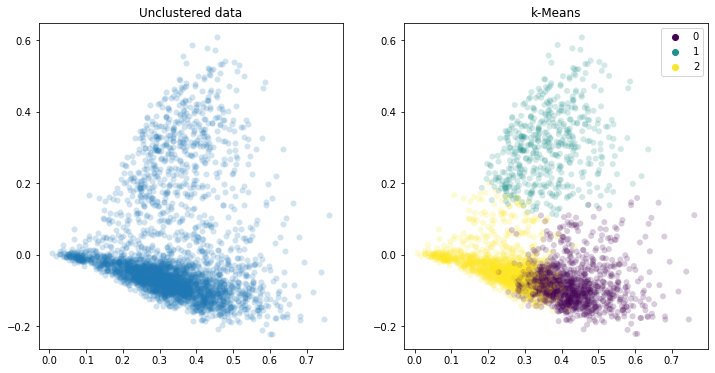

In [10]:
# Perform k-Means clustering with n_clusters = 3

# Set up clsutering object
kmeans = KMeans(n_clusters=3)

# Perform clustering and return labels
%time y_kmeans = kmeans.fit_predict(X_bailey)

# Print label vector shape
print("kMeans label vector shape:", y_kmeans.shape)

# Plot results
plot_compare(X_bailey, y_kmeans, 'k-Means')

## 3. Analyze *k*-Means clustering results (15 points)

Use the supplied `pull_samples` function to examine 5 documents from each cluster (5 points). Then, write a paragraph analyzing your results (10 points). 

Can you make sense of the clusters? Do the cases look like what you expected? Do the calculated clusters strike you as meaningfully distinct? Do you think justice was done in the cases you examined? Anything else that stands out?

In [9]:
# Your sample-pulling code here
pull_samples(bailey, y_kmeans, 5)

Label: 0
Number of texts in this cluster: 1493 

Sample text: 896
and were indicted for stealing, on the 19th of July , 500 lamps, value 6 l. , the goods of . . I am a lamp contractor . Blowes lived ten months with me; the other was employed occasionally. A few days before the Coronation I counted my stock of lamps, and had between eight and nine thousand; after the Coronation I had them counted, and found 891 deficient. I gave\ in\ formation at Bow-street. Davey said, that my man took the lamps out of my warehouse, and gave them to him, and he sold them to Anderson, who keeps a tin-shop. I brought Davey to the shop, and took Blowes down at his own house, at Westminster, he said, he hoped I would not hurt him, but he did take a quantity of lamps, two or three times, and gave them to Davey. I got a search-warrant, and found them at Anderson's. . I am a furnishing ironmonger, and live at No. 19, Wardour-street. Davey brought me three dozen of lamps to sell, about the time of the Coronati

**Your discussion of the *k*-Means results here**

## 4. Spectral clustering (30 points)

*k*-Means is just one approach to clustering. Here, you'll produce produce a **Spectral clustering**, with cosine similarity, as a point of comparison. You may want to consult the scikit-learn [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) documentation.

You must:

1. Set up a `SpectralClustering` object with `n_clusters=3` and `affinity='precomputed'`
1. Calculate the pairwise `cosine_similarity` matrix on your vectorized input data
1. Compute a spectral clustering on the cosine similarity matrix, storing the output labels in a variable named `y_spectral`
1. Print the shape of your output label vector
1. Plot your results using the `plot_compare` function
1. Pull and print 5 sample cases belonging to each cluster using the `pull_samples` function
1. Discuss the results of your spectral clustering, both on their own and in comparison to the *k*-Means results. About an honest aragraph should be sufficient.

In [10]:
# Your spectral clustering code

# Clustering object
spectral_clusterer = SpectralClustering(
    n_clusters=3,
    affinity='precomputed'
)

# Cosine affinitiy matrix
cosine_affinity = cosine_similarity(X_bailey)

# Perform clustering on similarity matrix
y_spectral = spectral_clusterer.fit_predict(cosine_affinity)

# Print label shape
print("Spectral label vector shape:", y_spectral.shape)

Spectral label vector shape: (3090,)


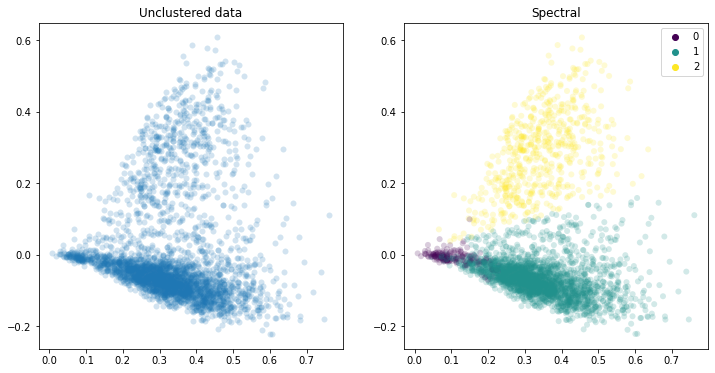

In [11]:
# Plot spectral results
plot_compare(X_bailey, y_spectral, 'Spectral')

In [12]:
# Pull spectral samples
pull_samples(bailey, y_spectral, 5)

Label: 0
Number of texts in this cluster: 177 

Sample text: 1958
was indicted for stealing, on the 28th of August , thirty pairs of boots, value 3 l., and four pairs of shoes, value 12 s., the goods of , in his dwelling-house . The prosecutor did not appear . NOT GUILTY. 

Sample text: 2465
was indicted for stealing, on the 26th of October , 1 watch-chain, value 10l.; 2 seals, value 4l., and 5 trinkets, value 1l., the goods of , from his person . The prosecutor did not appear. NOT GUILTY . 

Sample text: 420
was indicted for stealing, on the 4th of December , one watch, value 3 l., the goods of , from his person . The prosecutor did not appear. NOT GUILTY . First Middlesex Jury, before Mr. 

Sample text: 1713
was indicted for stealing, on the 13th of June , one handkerchief, value 1 s., the goods of , from his person . The prosecutor did not appear. NOT GUILTY . Second Middlesex Jury, before Mr. Common Sergeant. 

Sample text: 155
, and were again indicted for forgery . MR. BOLLAND fo

**Your discussion of the spectral clustering results here**

## 5. Any other clustering method (25 points)

Perform the same steps as in the *k*-Means and Spectral clustering cases (set up with appropriate options, compute labels, print label vector dimensions, plot, pull samples, and discuss results), but using a different clustering method from among [those offered by scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering). Say something brief about why you chose the method you did as part of your discussion.

Note: You'll want to pay particular attention to data input formats and to any key parameters of your chosen clustering method. Just as Spectral clustering required an affinity (similarity) matrix as input, some methods want a precomputed distance or similarity matrix as input. Others are very sensitive to options (like epsilon in DBSCAN). Work with care and note in your discussion any choices that you feel were important.

In [13]:
# Your code here

**Your discussion here**

### Example 5.1: Density-based clustering

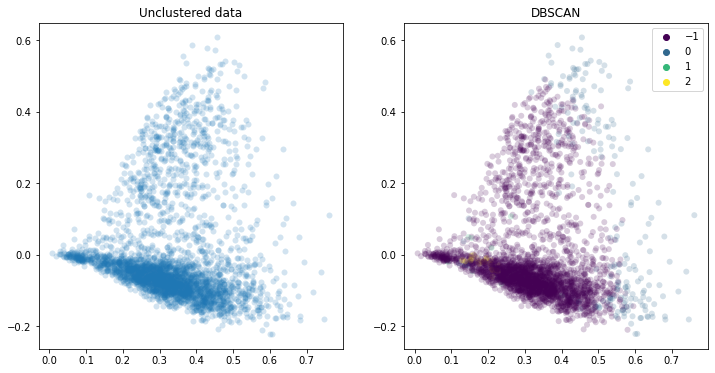

In [14]:
density_clusterer = DBSCAN(
    metric='cosine',
    min_samples=10,
    eps=0.5
)
y_dbscan = density_clusterer.fit_predict(X_bailey)
plot_compare(X_bailey, y_dbscan, 'DBSCAN')

In [15]:
pull_samples(bailey, y_dbscan)

Label: -1
Number of texts in this cluster: 2845 

Sample text: 1874
was indicted for stealing, on the 20th of September , a book, value 6 s. , the goods of . I am a bookseller , and live in Gray's Inn-passage . On the 20th of September, between five and six o'clock in the evening, I saw the prisoner take a book off my stall-board; it was Boyer's French and English Dictionary. I went after him - he began to run, and when he got about fifty yards he dropped it. I called out Stop thief! and picked it up. He was gone some distance - several pursued. I lost sight of him, but am certain of him - he was brought back, and said, "You know me, Mr. Wilton, my name is ; you had me transported before, and I have done this out of revenge" - I immediately said, "I do know you, and am sorry you should have come back again." He had been sent to the Penitentiary, about May, 1819. Cross-examined by MR. LAW. Q. Might he not have said, "I am not likely to have done this, when I have been transported before

### Example 5.2 Agglomerative clustering

In [16]:
%%time
agg_clusterer = AgglomerativeClustering(
    n_clusters=3,
    affinity='cosine',
    linkage='average'
)

y_agg = agg_clusterer.fit_predict(X_bailey.toarray())
print(y_agg.shape)

(3090,)
CPU times: user 1min 4s, sys: 598 ms, total: 1min 5s
Wall time: 1min 9s


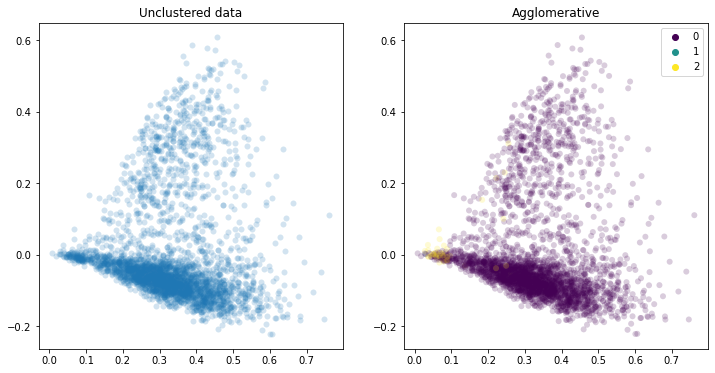

In [17]:
plot_compare(X_bailey, y_agg, 'Agglomerative')

In [18]:
pull_samples(bailey, y_agg)

Label: 0
Number of texts in this cluster: 3045 

Sample text: 2127
was indicted for stealing, on the 1st of January , sixteen hats, value 2 l. , the goods of . MARK MARKS. I am a hatter , and live in Crown-street, St. Giles's . The prisoner lives opposite my workshop, which is No. 18. On the 1st of January I went to my workshop, about half-past twelve o'clock, and found the place in confusion - sixteen hats, which had been safe the night before, were gone - I likewise lost a bag. In consequence of what I heard I went to White's house, and saw his mother, but he was not there. When his mother saw me on the Saturday she said he should tell me all about the robbery; I went again, and then saw the prisoner in the kitchen - he said, if I came with any pig man he would knock my head off, but as I came alone he would tell me. I had not said anything to induce him to tell me; I had given the mother 6 d. to get some gin, but she did not have it till it was all done. I asked him who the parties 